In [1]:
import uproot
import numpy as np
import awkward as ak

from coffea.nanoevents import NanoEventsFactory, BaseSchema
from agc_schema import AGCSchema

In [2]:
import json
with open('ntuples.json', 'r') as f:
    metadata = json.load(f)

# Function to calculate the integrated luminosity in case we couldn't access all of the files
def getLumi(nevts):
    lumi_nom = 2256.38 # total possible luminosity in /pb
    sf = float(nevts)/36619019
    return lumi_nom*sf 

# Useful function to calculate weight, pass the sample name, 
# total_events summed over files accessed and lumi calculated from function above
def getEventWeight(sample,n_total_events,lumi):
    if sample != "data": # we don't weight the real data
        xsec_weight = metadata[sample]['filter_eff']*metadata[sample]['xsec'] * lumi / (n_total_events)
    else:
        xsec_weight = 1
    return xsec_weight

In [3]:
# define the binning for my observable (m_bjj)
obsbins=np.arange(50,575,25)

In [4]:
# define a function that will run over the analysis for any input file 

import time
import matplotlib.pyplot as plt

def runAnalysis(input_file,isMC=True):
    try: 
        events = NanoEventsFactory.from_root(input_file, schemaclass=AGCSchema, treepath='events').events()
    except OSError:
        time.sleep(2) # sleep for 2 seconds and try one more time
        try: 
            events = NanoEventsFactory.from_root(input_file, schemaclass=AGCSchema, treepath='events').events()
        except OSError:
            time.sleep(2) # sleep for 2 seconds just to not try EOS again but give up on this file now
            return []
    
    # Object selection
    selected_electrons = events.electron[(events.electron.pt > 30) & (abs(events.electron.eta)<2.1) & (events.electron.isTight == True) & (events.electron.sip3d < 4 )]
    selected_muons = events.muon[(events.muon.pt > 30) & (abs(events.muon.eta)<2.1) & (events.muon.isTight == True) & (events.muon.sip3d < 4) & (events.muon.pfreliso04DBCorr < 0.15)]
    selected_jets = events.jet[(events.jet.corrpt > 30) & (abs(events.jet.eta)<2.4) ]
    
    # Event selection
    event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
    event_filters = event_filters &  (ak.count(selected_jets.corrpt, axis=1) >= 4) & (ak.sum(selected_jets.btag >= 0.8, axis=1) >= 2)
    selected_events = selected_jets[event_filters]
    
    # calculate scale up/down 
    if isMC:
        selected_events['scaleUp']   = selected_events.corrptUp/selected_events.corrpt
        selected_events['scaleDown'] = selected_events.corrptDown/selected_events.corrpt
    
    # Calculate observable and for the scale up/down
    trijet = ak.combinations(selected_events, 3, fields=["j1", "j2", "j3"])
    j1,j2,j3 = ak.unzip(trijet)
    has_bjet = (ak.sum(j1.btag>=0.8,axis=1)+ak.sum(j2.btag>=0.8,axis=1)+ak.sum(j3.btag>=0.8,axis=1)>0)
    trijet = trijet[has_bjet]
    
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3
    trijet_mass  = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    observable = ak.flatten(trijet_mass).to_numpy()
    
    # create counts in bins 
    counts_bin_edges  = plt.hist(observable,bins=obsbins)
    counts, bin_edges = counts_bin_edges[0],counts_bin_edges[1]
    
    if isMC:
        trijet["p4Up"]   = trijet.j1.multiply(trijet.j1.scaleUp) +trijet.j2.multiply(trijet.j2.scaleUp)+trijet.j3.multiply(trijet.j3.scaleUp) 
        trijet["p4Down"] = trijet.j1.multiply(trijet.j1.scaleDown) +trijet.j2.multiply(trijet.j2.scaleDown)+trijet.j3.multiply(trijet.j3.scaleDown) 
    
        trijet_massU = trijet["p4Up"][ak.argmax(trijet.p4Up.pt, axis=1, keepdims=True)].mass
        trijet_massD = trijet["p4Down"][ak.argmax(trijet.p4Down.pt, axis=1, keepdims=True)].mass
    
        observableU = ak.flatten(trijet_massU).to_numpy()
        observableD = ak.flatten(trijet_massD).to_numpy()
    
   
        countsU_bin_edges  = plt.hist(observableU,bins=obsbins)
        countsU, bin_edges = countsU_bin_edges[0],countsU_bin_edges[1]
    
        countsD_bin_edges  = plt.hist(observableD,bins=obsbins)
        countsD, bin_edges = countsD_bin_edges[0],countsD_bin_edges[1]
    
    plt.clf()
    
    # return the counts 
    if isMC: return {'nominal':np.array(counts),'jesUp':np.array(countsU),'jesDown':np.array(countsD)}
    else : return {'nominal':np.array(counts)}


In [5]:
from hist2df import * 

samples=[
    'data'
    ,'ttbar'
    ,'single_atop_t_chan'
    ,'single_top_t_chan'
    ,'single_top_tW'
    ,'wjets'
]


n_sim_samples = len(samples)-1

# first run over the data. We want to keep track of the total number of events 
# that get accessed so that we can modify the integrated luminosity if necessary 

print('data')
counts = {'nominal':np.array([0. for i in range(len(obsbins)-1)])}
total_events = 0

MAX_FILES = -1 # if a negative number, then we don't set a maximum on the number of files. 

for j,p in enumerate(metadata['data']['nominal']['files']): 
    
    # for each file, we add the counts from these events
    if (MAX_FILES > 0 and j > MAX_FILES): continue
    print(j,p['path'])

    event_counts = runAnalysis(p['path'],isMC=False)
    if len(event_counts):
        counts['nominal'] += event_counts['nominal']
        total_events+=p['nevts'] 
 
    else : print("skipped file (XRootD error)")
    

intlumi = getLumi(total_events)
print("Data total events accessed", total_events, " -> %g /pb"%intlumi )
                 
# convert to dataframe 
dfs = histogramToDataframe(counts['nominal'],"signalregion",'data')
                
# Now we run over the simulated samples. Again, we should keep track of the number of events  
# that get accessed so that we can calculate the right event_weight

for i,sample in enumerate(samples[1:]): 
    if sample=='data': continue # shouldn't need this 
    print(sample)
    
    # make sure to zero out the counts for each sample 
    counts = {
         'nominal':np.array([0. for i in range(len(obsbins)-1)])
        ,'jesUp':np.array([0. for i in range(len(obsbins)-1)])
        ,'jesDown':np.array([0. for i in range(len(obsbins)-1)])
    }
    
    total_sim_events = 0
    
    for j,p in enumerate(metadata[sample]['nominal']['files']): 
        
        if (MAX_FILES > 0 and j > MAX_FILES): continue
        print(j,p['path'])
        # for each file, we add the counts from these events
        event_counts = runAnalysis(p['path'])
        if len(event_counts):
            counts['nominal'] += event_counts['nominal']
            counts['jesUp']   += event_counts['jesUp']
            counts['jesDown'] += event_counts['jesDown']
            total_sim_events+=p['nevts'] 
           
        else : print("skipped file (XRootD error)")
        
            
    event_weight = getEventWeight(sample,total_sim_events,intlumi)
    print("Total events processed (%s):"%(sample), total_sim_events, 
          "XSec = ",metadata[sample]['xsec'], 
          "Filter efficiency = ", metadata[sample]['filter_eff'], 
          "Event weight = ", event_weight)
        
    # now that we have the counts, we convert to a dataframe 
    dfs_sample_n = histogramToDataframe(counts['nominal'],"signalregion",sample)
    dfs_sample_jesUp   = histogramToDataframe(counts['jesUp'],"signalregion",sample,sys='jesUp')
    dfs_sample_jesDown = histogramToDataframe(counts['jesDown'],"signalregion",sample,sys='jesDown')
    
    dfs_sample = pd.concat([dfs_sample_n,dfs_sample_jesUp,dfs_sample_jesDown],ignore_index=True)
    
    # apply weight to columns
    dfs_sample['sum_w']*=event_weight
    dfs_sample['sum_ww']*=event_weight*event_weight
    
    # add the new sample into our dataframe
    dfs = pd.concat([dfs,dfs_sample,],ignore_index=True)

data
0 root://eospublic.cern.ch//eos/opendata/cms/derived-data/POET/23-Jul-22/Run2015D_SingleMuon_flat/07FC2CD2-106C-4419-9260-12B3E271C345_flat.root
1 root://eospublic.cern.ch//eos/opendata/cms/derived-data/POET/23-Jul-22/Run2015D_SingleMuon_flat/0935DABA-2ECA-4F6B-A880-34594A5AE8FA_flat.root
2 root://eospublic.cern.ch//eos/opendata/cms/derived-data/POET/23-Jul-22/Run2015D_SingleMuon_flat/0B54B6B7-3F0C-4106-BEF6-C64CDE42CB72_flat.root
skipped file (XRootD error)
3 root://eospublic.cern.ch//eos/opendata/cms/derived-data/POET/23-Jul-22/Run2015D_SingleMuon_flat/1130E0AD-1ED1-4B31-AC3E-DC61B5D79552_flat.root
4 root://eospublic.cern.ch//eos/opendata/cms/derived-data/POET/23-Jul-22/Run2015D_SingleMuon_flat/12FBD489-A0D5-4DCF-AE97-59C79EE59964_flat.root
5 root://eospublic.cern.ch//eos/opendata/cms/derived-data/POET/23-Jul-22/Run2015D_SingleMuon_flat/147AD171-2B23-4E8D-83FF-0D632170BA4E_flat.root
6 root://eospublic.cern.ch//eos/opendata/cms/derived-data/POET/23-Jul-22/Run2015D_SingleMuon_flat

/usr/local/venv/lib/python3.10/site-packages/awkward/_connect/_numpy.py:197: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


3 root://eospublic.cern.ch//eos/opendata/cms/derived-data/POET/23-Jul-22/RunIIFall15MiniAODv2_TT_TuneCUETP8M1_13TeV-powheg-pythia8_flat/0A514982-0995-497E-9B65-B754B4B0E796_flat.root
4 root://eospublic.cern.ch//eos/opendata/cms/derived-data/POET/23-Jul-22/RunIIFall15MiniAODv2_TT_TuneCUETP8M1_13TeV-powheg-pythia8_flat/0A688F77-7EA0-4935-B33C-56CE7AA786E2_flat.root
5 root://eospublic.cern.ch//eos/opendata/cms/derived-data/POET/23-Jul-22/RunIIFall15MiniAODv2_TT_TuneCUETP8M1_13TeV-powheg-pythia8_flat/0C031340-8011-496F-BADB-30D042E09228_flat.root
6 root://eospublic.cern.ch//eos/opendata/cms/derived-data/POET/23-Jul-22/RunIIFall15MiniAODv2_TT_TuneCUETP8M1_13TeV-powheg-pythia8_flat/12D782DF-337C-41E0-98F2-7E9B10E9B932_flat.root
7 root://eospublic.cern.ch//eos/opendata/cms/derived-data/POET/23-Jul-22/RunIIFall15MiniAODv2_TT_TuneCUETP8M1_13TeV-powheg-pythia8_flat/13BF7F15-9EBD-4ABF-BD01-81262A7CCE29_flat.root
8 root://eospublic.cern.ch//eos/opendata/cms/derived-data/POET/23-Jul-22/RunIIFall15M

<Figure size 432x288 with 0 Axes>

          channel process systematic  bin        sum_w       sum_ww
0    signalregion    data    nominal    0    87.000000    87.000000
1    signalregion    data    nominal    1   582.000000   582.000000
2    signalregion    data    nominal    2  1945.000000  1945.000000
3    signalregion    data    nominal    3  4267.000000  4267.000000
4    signalregion    data    nominal    4  6756.000000  6756.000000
..            ...     ...        ...  ...          ...          ...
331  signalregion   wjets    jesDown   16    94.275456    61.721261
332  signalregion   wjets    jesDown   17    90.347312    59.149542
333  signalregion   wjets    jesDown   18    70.051901    45.862326
334  signalregion   wjets    jesDown   19    52.375253    34.289590
335  signalregion   wjets    jesDown   20     0.000000     0.000000

[336 rows x 6 columns]
Integrated luminosity =  2009.8193315659278  /pb


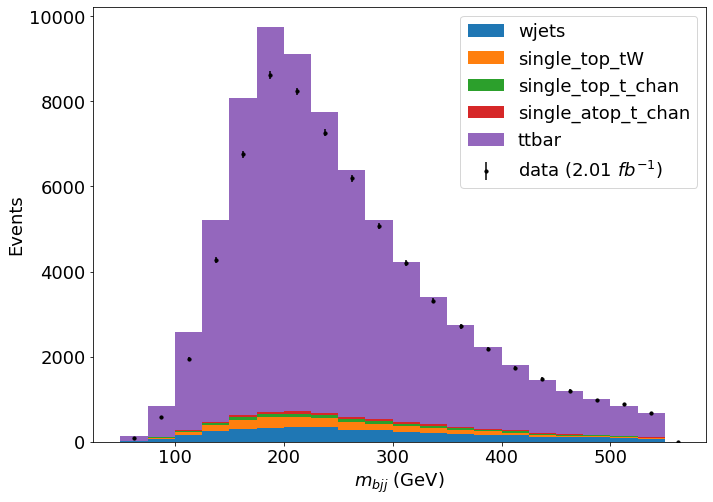

In [6]:
print(dfs)
plt.rcParams.update({'font.size': 18})

order_sim = samples[1:]
order_sim.reverse() # plot stack in reverse 

# need to make list structures for this to work in stacked mode 
bin_centres = np.array(obsbins)+25./2
bins_list = [obsbins for b in range(n_sim_samples)]
samples_stack = [dfs[ (dfs['process']==s) & (dfs['systematic']=='nominal')]['sum_w'].to_list() for s in order_sim]
labels = order_sim

plt.figure(figsize=(11,8))

plt.hist(bins_list,bins=obsbins,weights=samples_stack,label=labels,stacked=True,density=False)
plt.errorbar(bin_centres,dfs[ (dfs['process']=='data') & (dfs['systematic']=='nominal')]['sum_w']
             ,yerr=(dfs[ (dfs['process']=='data') & (dfs['systematic']=='nominal')]['sum_ww'])**0.5
             ,label='data (%.2f $fb^{-1}$)'%(intlumi/1000)
             ,marker='o'
             ,markersize=3.2
             ,color='black'
             ,linestyle="none")
plt.xlabel("$m_{bjj}$ (GeV)")
plt.ylabel("Events")

plt.legend()
print("Integrated luminosity = ", intlumi," /pb")

plt.savefig("mbjj_signalregion.png")

In [7]:
# sort the dataframe to avoid warnings later
dfs = dfs.sort_values(by=['process','systematic','bin'])

# Finally save histograms to a csv file
dfs.to_csv('signalregion_mbjj.csv',index=False)